In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [2]:
#dataset = pd.read_csv('../dataset-processed/pre-processed-01.csv')
dataset = pd.read_csv('../dataset-processed/pre-processed-02-brand-paid.csv')
print("Numero di esempi: ", len(dataset))
dataset.head()

Numero di esempi:  11905


,hashtag,tag,caption,is_video,n_comment,n_likes,target,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
0,0,0,52,0,0.000116,0.042888,1,0,0,0,1,0,0
1,0,0,44,0,0.000174,0.057932,1,0,1,0,0,0,0
2,2,4,16,1,0.000044,0.019899,1,0,0,1,0,0,0
3,0,0,1,1,0.000256,0.042174,1,0,1,0,0,0,0
4,0,1,26,0,0.000099,0.042953,1,1,0,0,0,0,0


### Feature selection

In [3]:
from sklearn.feature_selection import SelectKBest, chi2

In [4]:
X = dataset.drop(labels=['target'], axis = 1)
y = dataset['target']

In [5]:
X.shape

(11905, 12)

In [6]:
X = SelectKBest(chi2, k=7).fit_transform(X, y)

In [7]:
X.shape

(11905, 7)

### Z-score

In [8]:
# z-score
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

### Inflate

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())
X_train.shape, y_train.shape

((18272, 7), (18272,))

In [12]:
print('Esempi training standard: ', sum(y_train == 1))
print('Esempi training paid: ', len(X_train) - sum((y_train == 0)))

Esempi training standard:  9136
Esempi training paid:  9136


### Neural network model

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
print(tf.__version__)

2.1.0


In [14]:
def create_model():
    model = Sequential()
    model.add(Dense(X.shape[1], activation="relu", input_dim = X.shape[1]))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
model = create_model()
history = model.fit(X_train, y_train, batch_size = 10, epochs = 10, verbose = 1, validation_data=(X_test, y_test))

Train on 18272 samples, validate on 2381 samples
Epoch 1/10
18272/18272 [==============================] - 4s 228us/sample - loss: 0.4354 - accuracy: 0.8077 - val_loss: 0.5210 - val_accuracy: 0.7316
Epoch 2/10
18272/18272 [==============================] - 4s 208us/sample - loss: 0.3767 - accuracy: 0.8399 - val_loss: 0.4497 - val_accuracy: 0.7610
Epoch 3/10
18272/18272 [==============================] - 4s 220us/sample - loss: 0.3568 - accuracy: 0.8468 - val_loss: 0.4250 - val_accuracy: 0.7871
Epoch 4/10
18272/18272 [==============================] - 4s 241us/sample - loss: 0.3412 - accuracy: 0.8533 - val_loss: 0.4220 - val_accuracy: 0.7883
Epoch 5/10
18272/18272 [==============================] - 4s 209us/sample - loss: 0.3309 - accuracy: 0.8575 - val_loss: 0.4453 - val_accuracy: 0.7799
Epoch 6/10
18272/18272 [==============================] - 4s 205us/sample - loss: 0.3204 - accuracy: 0.8619 - val_loss: 0.3574 - val_accuracy: 0.8207
Epoch 7/10
18272/18272 [===========================

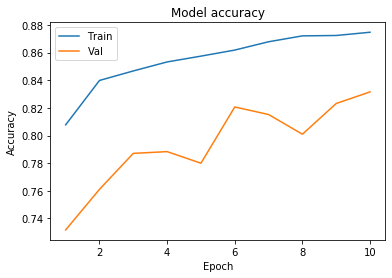

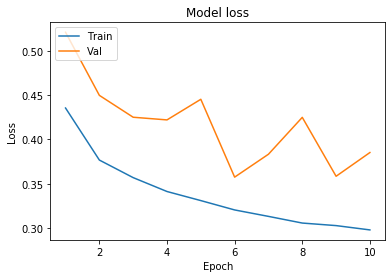

In [16]:
# Plot training & validation accuracy values
epoch_range = range(1, 11)
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Evaluate the model

In [17]:
y_pred = model.predict_classes(X_test)
accuracy_score(y_test, y_pred)

0.8315833683326334

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a369156a0>)

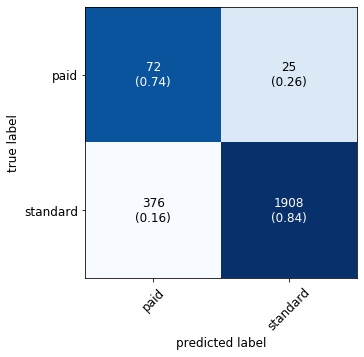

In [18]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.16      0.74      0.26        97
           1       0.99      0.84      0.90      2284

    accuracy                           0.83      2381
   macro avg       0.57      0.79      0.58      2381
weighted avg       0.95      0.83      0.88      2381

